In [1]:
import os
import json
import cv2
import torch
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

ROOT_DIR = "/kaggle/input/svideoqa/SVideoQA_Dataset_v1"

ACTION_KEYWORDS = ["walking", "sitting", "running", "carrying", "holding", "looking", 
                   "standing", "jumping", "turning", "raising", "waving"]

In [2]:
def extract_actions_from_annotations(root_dir):
    action_data = defaultdict(list)
    for sequence in sorted(os.listdir(root_dir)):
        seq_path = os.path.join(root_dir, sequence)
        if not os.path.isdir(seq_path) or "videosequence-149" in sequence:
            continue  
        
        for subject in os.listdir(seq_path):
            subject_path = os.path.join(seq_path, subject)
            if not os.path.isdir(subject_path):
                continue
            
            for camera in os.listdir(subject_path):
                cam_path = os.path.join(subject_path, camera)
                if not os.path.isdir(cam_path) or "Camera02" in camera:
                    continue
                
                for annotation_file in os.listdir(cam_path):
                    annotation_path = os.path.join(cam_path, annotation_file)

                    if annotation_file.endswith(".xls"):
                        try:
                            df = pd.read_excel(annotation_path, engine="xlrd")
                        except Exception as e:
                            print(f"Error reading {annotation_path}: {e}")
                            continue
                    elif annotation_file.endswith(".csv"):
                        try:
                            df = pd.read_csv(annotation_path)  
                        except Exception as e:
                            print(f"Error reading {annotation_path}: {e}")
                            continue
                    else:
                        continue  
                    
                    for _, row in df.iterrows():
                        question = str(row.get("question", "")).lower()
                        answer = str(row.get("answer", "")).lower()
                        for keyword in ACTION_KEYWORDS:
                            if keyword in question or keyword in answer:
                                action_data[sequence].append(keyword)
    
    for key in action_data:
        action_data[key] = list(set(action_data[key]))
    
    return action_data

In [3]:
actions_mapping = extract_actions_from_annotations(ROOT_DIR)

action_vocab = sorted(set(action for actions in actions_mapping.values() for action in actions))
action_to_index = {action: idx for idx, action in enumerate(action_vocab)}
num_classes = len(action_vocab)

In [4]:
with open("action_to_index.json", "w") as f:
    json.dump(action_to_index, f, indent=4)

print(f"Total Actions: {num_classes}")
print(f"Action Mapping: {action_to_index}")

Total Actions: 8
Action Mapping: {'carrying': 0, 'holding': 1, 'looking': 2, 'sitting': 3, 'standing': 4, 'turning': 5, 'walking': 6, 'waving': 7}


In [5]:
from concurrent.futures import ThreadPoolExecutor

class SVideoQADataset(Dataset):
    def __init__(self, root_dir, actions_mapping, transform=None, frames_per_clip=16):
        self.root_dir = root_dir
        self.actions_mapping = actions_mapping  
        self.transform = transform
        self.frames_per_clip = frames_per_clip
        self.data = []
        self.labels = []
        self._load_data()

    def _load_data(self):
        sequence_paths = sorted(
            [os.path.join(self.root_dir, seq) for seq in os.listdir(self.root_dir) if "videosequence-149" not in seq]
        )

        for seq_path in sequence_paths:
            if not os.path.isdir(seq_path):
                continue

            sequence = os.path.basename(seq_path)
            action_labels = self.actions_mapping.get(sequence, [])

            subject_paths = [os.path.join(seq_path, s) for s in os.listdir(seq_path) if os.path.isdir(os.path.join(seq_path, s))]

            for subject_path in subject_paths:
                cam_paths = [
                    os.path.join(subject_path, c) 
                    for c in os.listdir(subject_path) 
                    if os.path.isdir(os.path.join(subject_path, c)) and "Camera02" not in c
                ]

                for cam_path in cam_paths:
                    frame_paths = self._get_sorted_frames(cam_path)
                    if len(frame_paths) == 0:
                        continue

                    selected_frames = self._sample_frames(frame_paths)
                    if selected_frames is not None:
                        self.data.append(selected_frames)
                        self.labels.append(action_labels)

    def _get_sorted_frames(self, cam_path):
        return sorted([
            os.path.join(cam_path, f) 
            for f in os.listdir(cam_path) if f.endswith(('.jpg', '.jpeg', '.png'))
        ])

    def _read_image(self, path):
        img = cv2.imread(path)
        if img is None:
            return None
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))
        return img

    def _compute_optical_flow(self, frame1, frame2):
        gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
        gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        return np.linalg.norm(flow, axis=2).mean()

    def _sample_frames(self, frame_paths):
        num_frames = len(frame_paths)
        if num_frames < 1:
            return None

        with ThreadPoolExecutor(max_workers=4) as executor:
            frames = list(executor.map(self._read_image, frame_paths))

        frames = [f for f in frames if f is not None]
        if len(frames) < 2:
            return None  

        flow_scores = np.zeros(len(frames))
        with ThreadPoolExecutor(max_workers=4) as executor:
            flow_scores[1:] = list(executor.map(self._compute_optical_flow, frames[:-1], frames[1:]))

        top_indices = np.argsort(flow_scores)[-self.frames_per_clip:]
        selected_frames = [frames[i] for i in sorted(top_indices)]

        return np.array(selected_frames) if len(selected_frames) == self.frames_per_clip else None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_clip = self.data[idx]
        action_labels = self.labels[idx]  
        label_indices = [action_to_index[action] for action in action_labels if action in action_to_index]
        label = label_indices[0] if label_indices else 0  

        if self.transform:
            video_clip = np.array([self.transform(frame) for frame in video_clip])

        return torch.tensor(video_clip, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


In [6]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),  
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
dataset = SVideoQADataset(ROOT_DIR, actions_mapping, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [8]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2, pin_memory=True)

print(f"Total Dataset Samples: {len(dataset)}")
print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")

Total Dataset Samples: 726
Train Dataset Size: 580
Validation Dataset Size: 146


In [30]:
import torch
import torch.nn as nn
from einops import rearrange
from timm.models.vision_transformer import Block

class MultiRegionCNN(nn.Module):
    def __init__(self):
        super(MultiRegionCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        B, T, C, H, W = x.size()
        x = x.view(B * T, C, H, W)
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(B, T, -1, x.size(2), x.size(3))
        return x 

In [32]:
class TimeSformer(nn.Module):
    def __init__(self, num_frames=16, img_size=56, patch_size=8, embed_dim=768, num_heads=12, depth=12,num_classes=len(action_to_index)):
        super(TimeSformer, self).__init__()
        self.num_patches = (img_size // patch_size) ** 2  
        self.patch_dim = patch_size * patch_size * 128  
        self.embed_dim = embed_dim
        self.num_frames = num_frames

        self.patch_embedding = nn.Linear(self.patch_dim, embed_dim)
        
        self.position_embedding = nn.Parameter(torch.zeros(1, self.num_frames * self.num_patches, embed_dim))
        self.temporal_embedding = nn.Parameter(torch.zeros(1, self.num_frames * self.num_patches, embed_dim))

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.dropout = nn.Dropout(0.3)

        self.blocks = nn.ModuleList([Block(embed_dim, num_heads) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)

        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        B, T, C, H, W = x.size()

        x = rearrange(x, 'b t c (h p1) (w p2) -> (b t) (h w) (p1 p2 c)', p1=8, p2=8)
        x = x.view(B * T, self.num_patches, self.patch_dim)

        x = self.patch_embedding(x)
        x = x + self.position_embedding[:, :x.shape[1], :]

        x = rearrange(x, '(b t) n d -> b (t n) d', b=B)
        x = x + self.temporal_embedding[:, :x.shape[1], :]  

        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = self.dropout(x)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x[:, 0])  
        x = self.head(x)
        return x

In [33]:
class WTMRNet(nn.Module):
    def __init__(self, num_classes):
        super(WTMRNet, self).__init__()
        self.multi_region_cnn = MultiRegionCNN()
        self.timesformer = TimeSformer(num_classes=num_classes)
    
    def forward(self, x):
        x = self.multi_region_cnn(x)
        x = self.timesformer(x)
        return x

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(action_to_index)
model = WTMRNet(num_classes=num_classes).to(device)

In [42]:
def train_model(model, train_loader, val_loader, model_name):
    torch.cuda.empty_cache()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=2e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    scaler = torch.amp.GradScaler()
    
    num_epochs2 = 30  
    history = {
        "epochs2": [],  
        "train_loss2": [], 
        "train_acc2": [], 
        "val_loss2": [], 
        "val_acc2": []
    }

    for epoch in range(num_epochs2):
        start_time = time.time()
        model.train()
        total_loss, correct_train, total_train = 0, 0, 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs2}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            with torch.amp.autocast("cuda"):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            correct_train += (outputs.argmax(1) == labels).sum().item()
            total_train += labels.size(0)

        avg_train_loss = total_loss / len(train_loader)
        train_accuracy = correct_train / total_train

        model.eval()
        total_val_loss, correct_val, total_val = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                with torch.amp.autocast("cuda"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                total_val_loss += loss.item()
                correct_val += (outputs.argmax(1) == labels).sum().item()
                total_val += labels.size(0)

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val

        scheduler.step(avg_val_loss)

        history["epochs2"].append(epoch + 1)
        history["train_loss2"].append(avg_train_loss)
        history["train_acc2"].append(train_accuracy)
        history["val_loss2"].append(avg_val_loss)
        history["val_acc2"].append(val_accuracy)
        
        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1}/{num_epochs2}: Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f} | Time: {epoch_time:.2f}s")

    torch.save({'model_state_dict': model.state_dict(), 'history': history}, f"{model_name}.pth")
    print(f"Model and training history saved to {model_name}.pth")

In [43]:
train_model(model, train_loader, val_loader, model_name="WTMRNet_SVideoQA")

Epoch 1/30: 100%|██████████| 145/145 [00:44<00:00,  3.25it/s]


Epoch 1/30: Train Loss: 1.3273 | Train Acc: 0.5069 | Val Loss: 1.3613 | Val Acc: 0.4521 | Time: 51.30s


Epoch 2/30: 100%|██████████| 145/145 [00:43<00:00,  3.36it/s]


Epoch 2/30: Train Loss: 1.3156 | Train Acc: 0.5379 | Val Loss: 1.3798 | Val Acc: 0.4795 | Time: 49.77s


Epoch 3/30: 100%|██████████| 145/145 [00:44<00:00,  3.28it/s]


Epoch 3/30: Train Loss: 1.3155 | Train Acc: 0.5121 | Val Loss: 1.2981 | Val Acc: 0.5000 | Time: 50.53s


Epoch 4/30: 100%|██████████| 145/145 [00:43<00:00,  3.32it/s]


Epoch 4/30: Train Loss: 1.3020 | Train Acc: 0.5431 | Val Loss: 1.4091 | Val Acc: 0.4247 | Time: 50.60s


Epoch 5/30: 100%|██████████| 145/145 [00:43<00:00,  3.30it/s]


Epoch 5/30: Train Loss: 1.3254 | Train Acc: 0.5190 | Val Loss: 1.3455 | Val Acc: 0.4795 | Time: 50.35s


Epoch 6/30: 100%|██████████| 145/145 [00:43<00:00,  3.31it/s]


Epoch 6/30: Train Loss: 1.3325 | Train Acc: 0.4931 | Val Loss: 1.3787 | Val Acc: 0.3836 | Time: 50.34s


Epoch 7/30: 100%|██████████| 145/145 [00:43<00:00,  3.32it/s]


Epoch 7/30: Train Loss: 1.3252 | Train Acc: 0.5207 | Val Loss: 1.3791 | Val Acc: 0.3904 | Time: 50.14s


Epoch 8/30: 100%|██████████| 145/145 [00:43<00:00,  3.32it/s]


Epoch 8/30: Train Loss: 1.3179 | Train Acc: 0.5155 | Val Loss: 1.3297 | Val Acc: 0.4863 | Time: 50.19s


Epoch 9/30: 100%|██████████| 145/145 [00:43<00:00,  3.35it/s]


Epoch 9/30: Train Loss: 1.3627 | Train Acc: 0.4741 | Val Loss: 1.3185 | Val Acc: 0.4863 | Time: 49.73s


Epoch 10/30: 100%|██████████| 145/145 [00:43<00:00,  3.34it/s]


Epoch 10/30: Train Loss: 1.2790 | Train Acc: 0.5379 | Val Loss: 1.3096 | Val Acc: 0.4795 | Time: 49.93s


Epoch 11/30: 100%|██████████| 145/145 [00:43<00:00,  3.35it/s]


Epoch 11/30: Train Loss: 1.2817 | Train Acc: 0.5276 | Val Loss: 1.3132 | Val Acc: 0.4795 | Time: 50.14s


Epoch 12/30: 100%|██████████| 145/145 [00:43<00:00,  3.34it/s]


Epoch 12/30: Train Loss: 1.2862 | Train Acc: 0.5310 | Val Loss: 1.3210 | Val Acc: 0.4932 | Time: 49.97s


Epoch 13/30: 100%|██████████| 145/145 [00:43<00:00,  3.33it/s]


Epoch 13/30: Train Loss: 1.2695 | Train Acc: 0.5345 | Val Loss: 1.3200 | Val Acc: 0.4863 | Time: 50.15s


Epoch 14/30: 100%|██████████| 145/145 [00:43<00:00,  3.35it/s]


Epoch 14/30: Train Loss: 1.2678 | Train Acc: 0.5362 | Val Loss: 1.3183 | Val Acc: 0.5000 | Time: 49.92s


Epoch 15/30: 100%|██████████| 145/145 [00:43<00:00,  3.32it/s]


Epoch 15/30: Train Loss: 1.2909 | Train Acc: 0.5207 | Val Loss: 1.3147 | Val Acc: 0.4932 | Time: 50.22s


Epoch 16/30: 100%|██████████| 145/145 [00:43<00:00,  3.32it/s]


Epoch 16/30: Train Loss: 1.2653 | Train Acc: 0.5397 | Val Loss: 1.3122 | Val Acc: 0.4863 | Time: 50.24s


Epoch 17/30: 100%|██████████| 145/145 [00:43<00:00,  3.30it/s]


Epoch 17/30: Train Loss: 1.2672 | Train Acc: 0.5345 | Val Loss: 1.3193 | Val Acc: 0.4795 | Time: 50.58s


Epoch 18/30: 100%|██████████| 145/145 [00:43<00:00,  3.32it/s]


Epoch 18/30: Train Loss: 1.2626 | Train Acc: 0.5414 | Val Loss: 1.3053 | Val Acc: 0.4932 | Time: 50.47s


Epoch 19/30: 100%|██████████| 145/145 [00:43<00:00,  3.32it/s]


Epoch 19/30: Train Loss: 1.2636 | Train Acc: 0.5362 | Val Loss: 1.2990 | Val Acc: 0.4863 | Time: 50.30s


Epoch 20/30: 100%|██████████| 145/145 [00:43<00:00,  3.33it/s]


Epoch 20/30: Train Loss: 1.2591 | Train Acc: 0.5379 | Val Loss: 1.3005 | Val Acc: 0.5000 | Time: 50.09s


Epoch 21/30: 100%|██████████| 145/145 [00:43<00:00,  3.33it/s]


Epoch 21/30: Train Loss: 1.2567 | Train Acc: 0.5362 | Val Loss: 1.3083 | Val Acc: 0.4863 | Time: 49.91s


Epoch 22/30: 100%|██████████| 145/145 [00:43<00:00,  3.32it/s]


Epoch 22/30: Train Loss: 1.2559 | Train Acc: 0.5431 | Val Loss: 1.3190 | Val Acc: 0.4863 | Time: 50.16s


Epoch 23/30: 100%|██████████| 145/145 [00:43<00:00,  3.32it/s]


Epoch 23/30: Train Loss: 1.2468 | Train Acc: 0.5466 | Val Loss: 1.3122 | Val Acc: 0.4932 | Time: 50.29s


Epoch 24/30: 100%|██████████| 145/145 [00:43<00:00,  3.31it/s]


Epoch 24/30: Train Loss: 1.2513 | Train Acc: 0.5379 | Val Loss: 1.3266 | Val Acc: 0.4863 | Time: 50.32s


Epoch 25/30: 100%|██████████| 145/145 [00:43<00:00,  3.33it/s]


Epoch 25/30: Train Loss: 1.2419 | Train Acc: 0.5431 | Val Loss: 1.3222 | Val Acc: 0.4932 | Time: 50.42s


Epoch 26/30: 100%|██████████| 145/145 [00:43<00:00,  3.31it/s]


Epoch 26/30: Train Loss: 1.2446 | Train Acc: 0.5397 | Val Loss: 1.3300 | Val Acc: 0.4863 | Time: 50.25s


Epoch 27/30: 100%|██████████| 145/145 [00:43<00:00,  3.31it/s]


Epoch 27/30: Train Loss: 1.2441 | Train Acc: 0.5431 | Val Loss: 1.3272 | Val Acc: 0.4932 | Time: 50.25s


Epoch 28/30: 100%|██████████| 145/145 [00:43<00:00,  3.32it/s]


Epoch 28/30: Train Loss: 1.2412 | Train Acc: 0.5431 | Val Loss: 1.3118 | Val Acc: 0.4863 | Time: 50.04s


Epoch 29/30: 100%|██████████| 145/145 [00:43<00:00,  3.31it/s]


Epoch 29/30: Train Loss: 1.2411 | Train Acc: 0.5466 | Val Loss: 1.3264 | Val Acc: 0.4932 | Time: 50.37s


Epoch 30/30: 100%|██████████| 145/145 [00:43<00:00,  3.33it/s]


Epoch 30/30: Train Loss: 1.2369 | Train Acc: 0.5448 | Val Loss: 1.3253 | Val Acc: 0.4863 | Time: 50.50s
Model and training history saved to WTMRNet_SVideoQA.pth


In [46]:
checkpoint = torch.load("WTMRNet_SVideoQA.pth", map_location="cpu", weights_only=False)
history = checkpoint["history"]

In [48]:
epochs2 = history["epochs2"]
train_loss2 = history["train_loss2"]
train_acc2 = history["train_acc2"]
val_loss2 = history["val_loss2"]
val_acc2 = history["val_acc2"]

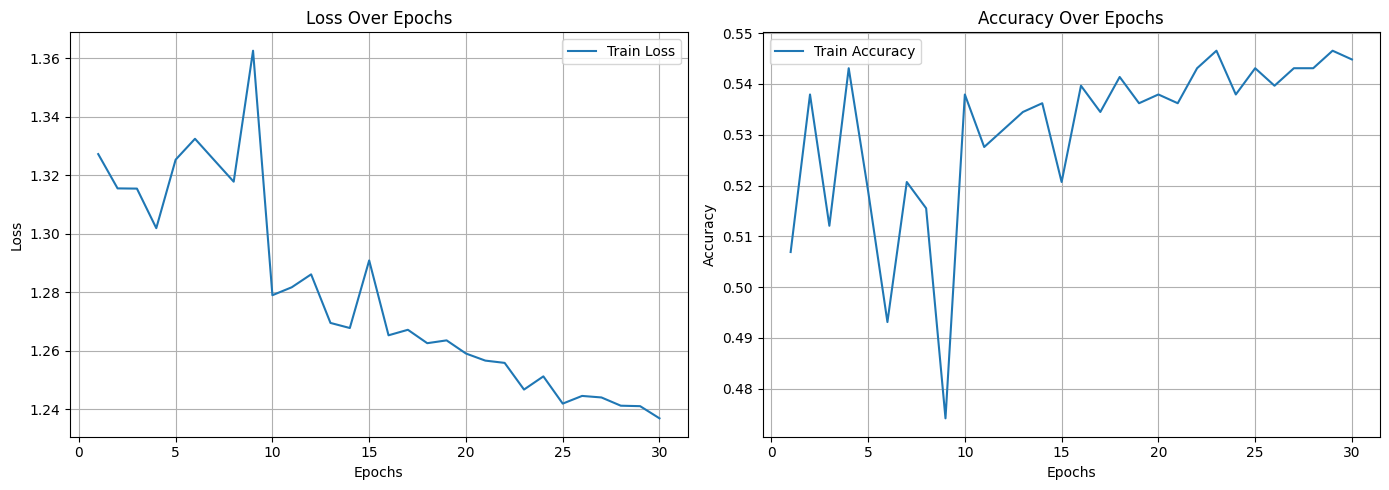

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].plot(epochs2, train_loss2, label="Train Loss", linestyle='-')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("Loss Over Epochs")
ax[0].legend()
ax[0].grid()

ax[1].plot(epochs2, train_acc2, label="Train Accuracy", linestyle='-')
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Accuracy Over Epochs")
ax[1].legend()
ax[1].grid()

plt.tight_layout()
plt.show()